In [85]:
!pip install pytorch_tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)
import seaborn as sns

import os

from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
train = pd.read_csv('/content/drive/MyDrive/CSV/Training.csv')


In [89]:
test = pd.read_csv('/content/drive/MyDrive/CSV/Testing.csv')

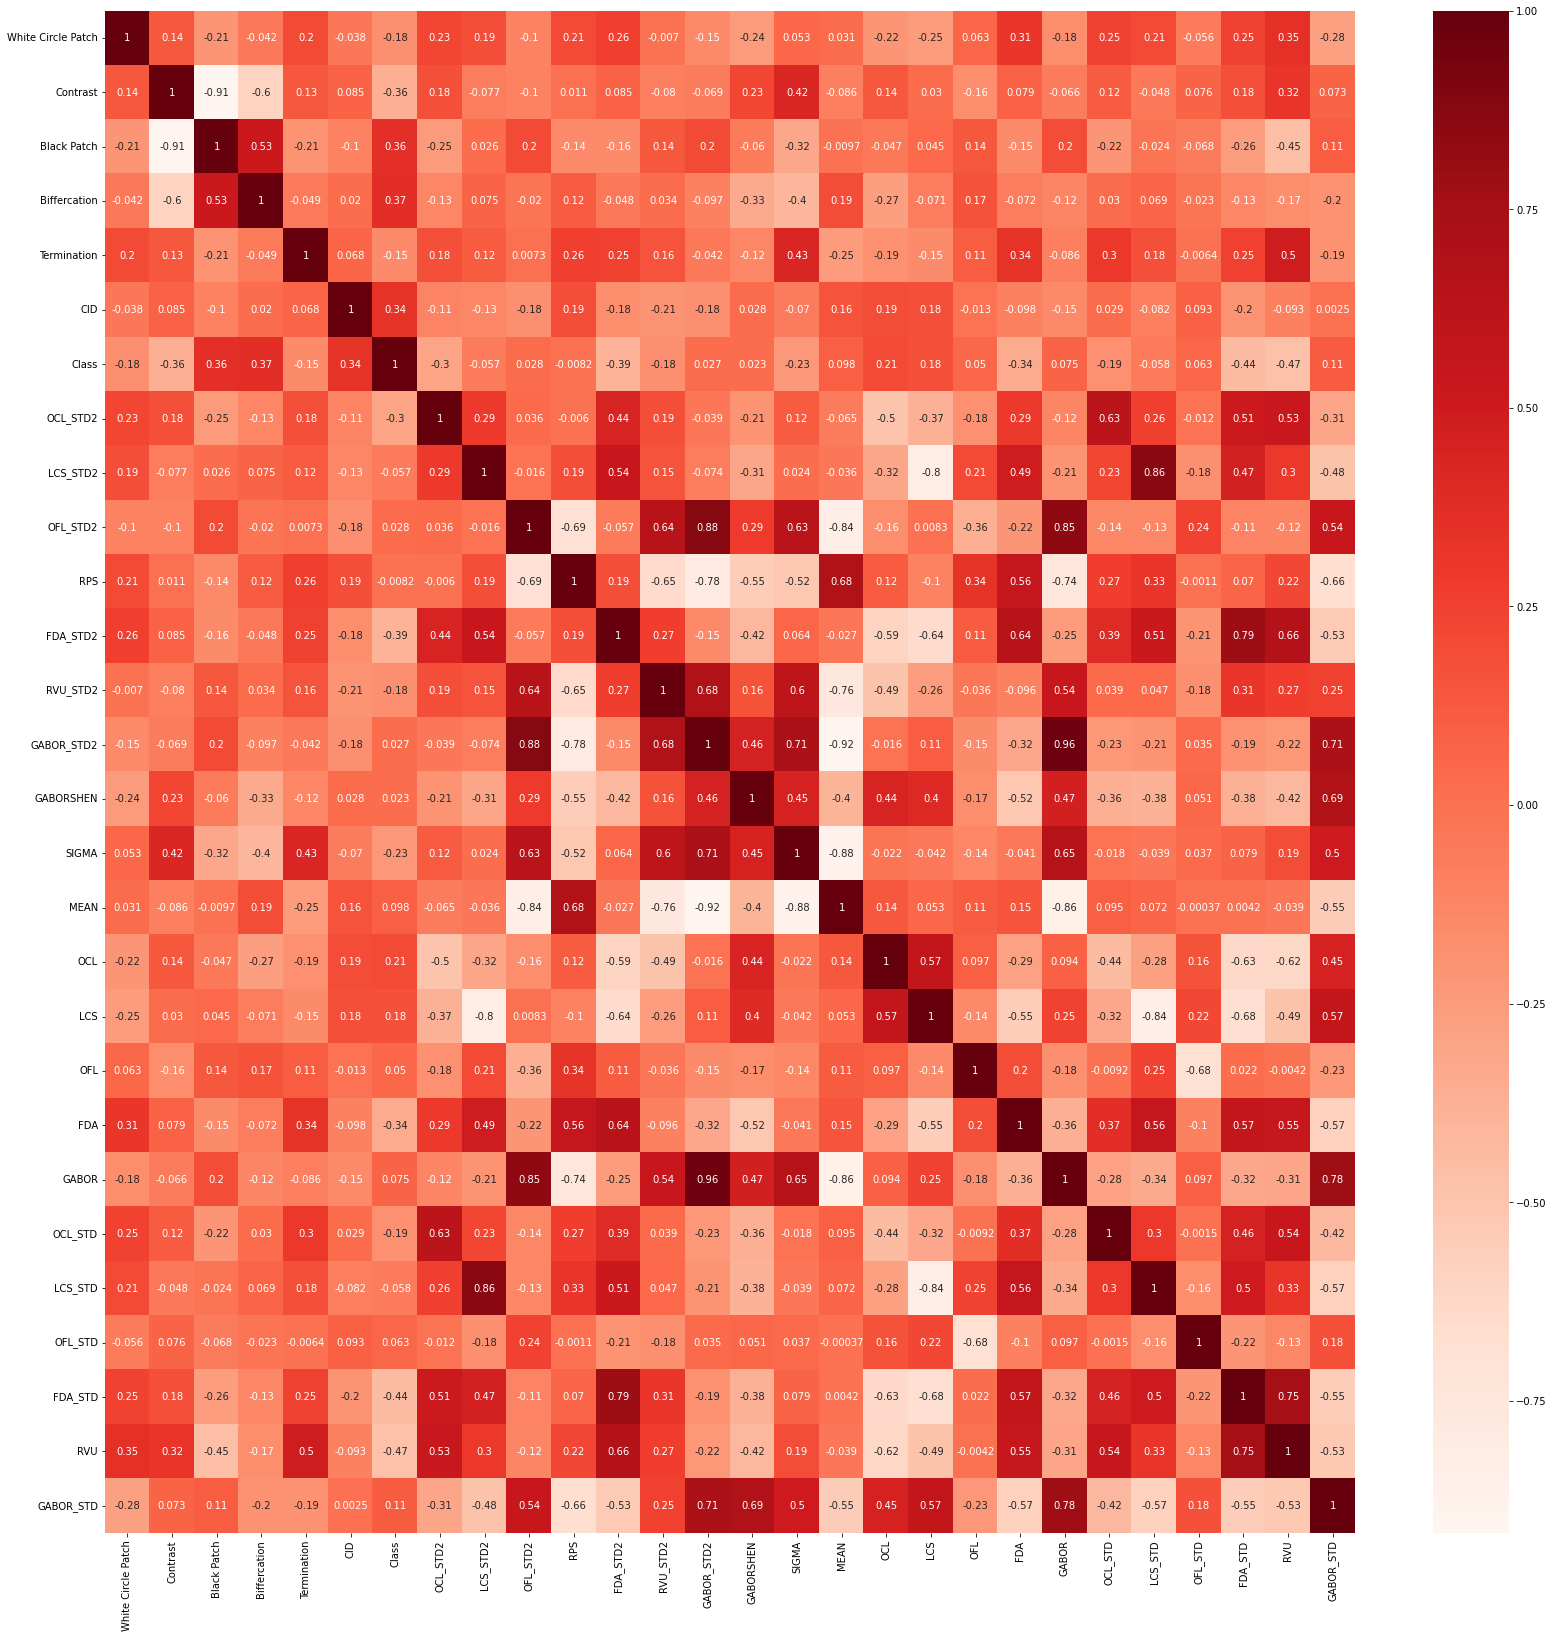

In [90]:
plt.figure(figsize=(28,28))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [91]:
cor_target = abs(cor["Class"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>=0.2]
relevant_features


Contrast        0.363611
Black Patch     0.361671
Biffercation    0.368299
CID             0.341060
Class           1.000000
OCL_STD2        0.297083
FDA_STD2        0.385601
SIGMA           0.232714
OCL             0.205841
FDA             0.342750
FDA_STD         0.439348
RVU             0.469879
Name: Class, dtype: float64

In [92]:
#97.2,94.6
#train = train[['Contrast','Black Patch','Biffercation','CID','Class','OCL_STD2','FDA_STD2','SIGMA','OCL','FDA','FDA_STD','RVU']].copy() #>=0.2,96%,92%

In [93]:
#test = test[['Contrast','Black Patch','Biffercation','CID','Class','OCL_STD2','FDA_STD2','SIGMA','OCL','FDA','FDA_STD','RVU']].copy() #>=0.2

In [94]:
if "Filename"  in train.columns:
    train.drop(["Filename"], axis = 1, inplace = True)
if "Filename"  in test.columns:
    test.drop(["Filename"], axis = 1, inplace = True)

In [95]:
target = 'Class'
if "Set"  in train.columns:
    train.drop(["Set"], axis = 1)
train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))
#train["Set"] = "train"    
train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index

In [96]:
if "Set" in test.columns:
  test.drop(['Set'], axis = 1)
test["Set"] = "test"
test_indices = test[test.Set=="test"].index

In [97]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Class 2
Set 2


In [98]:
train.head()

,Contrast,Black Patch,Biffercation,CID,Class,OCL_STD2,FDA_STD2,SIGMA,OCL,FDA,FDA_STD,RVU,Set
0,0.010333,0.999772,3804,107.771544,1,0.132002,0.355333,37.139012,0.414784,0.616894,0.356391,1.302933,0
1,0.003752,0.999955,5288,156.874296,1,0.125693,0.320952,44.398540,0.321220,0.515961,0.339769,1.328657,0
2,0.004532,0.999884,4861,218.001356,1,0.118022,0.317784,38.520881,0.348407,0.626022,0.364821,1.525489,0
3,0.047750,0.998029,1661,212.954369,1,0.097421,0.315834,32.829816,0.298576,0.591813,0.348423,1.267153,0
4,0.029279,0.999124,2026,181.324385,1,0.149858,0.328637,32.878617,0.308873,0.595702,0.343960,1.379756,0


In [99]:
nunique = test.nunique()
types = test.dtypes
for col in test.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, test[col].nunique())
        l_enc = LabelEncoder()
        test[col] = test[col].fillna("VV_likely")
        test[col] = l_enc.fit_transform(test[col].values)
    else:
        test.fillna(test.loc[test_indices, col].mean(), inplace=True)

Class 2
Set 1


In [100]:
train.loc[train[target]==0, target] = "classZero"
train.loc[train[target]==1, target] = "classOne"
test.loc[test[target]==0, target] = "classZero"
test.loc[test[target]==1, target] = "classOne"

In [101]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [102]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [103]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = test[features].values[test_indices]
y_test = test[target].values[test_indices]


In [104]:
X_train[0]

array([1.03334550e-02, 9.99772299e-01, 3.80400000e+03, 1.07771544e+02,
       1.32001804e-01, 3.55333434e-01, 3.71390116e+01, 4.14784012e-01,
       6.16894174e-01, 3.56390888e-01, 1.30293305e+00])

In [105]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [106]:
class ClassificationSMOTE():
    """
    Apply SMOTE for classification tasks.
    This will average a percentage p of the elements in the batch with other elements.
    The target will stay unchanged and keep the value of the most important row in the mix.
    """
    def __init__(self, device_name="auto", p=0.8, alpha=0.5, beta=0.5, seed=0):
        ""
        self.seed = seed
        self._set_seed()
        self.device = define_device(device_name)
        self.alpha = alpha
        self.beta = beta
        self.p = p
        if (p < 0.) or (p > 1.0):
            raise ValueError("Value of p should be between 0. and 1.")

    def _set_seed(self):
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        return

    def __call__(self, X, y):
        batch_size = X.shape[0]
        random_values = torch.rand(batch_size, device=self.device)
        idx_to_change = random_values < self.p

        # ensure that first element to switch has probability > 0.5
        np_betas = np.random.beta(self.alpha, self.beta, batch_size) / 2 + 0.5
        random_betas = torch.from_numpy(np_betas).to(self.device).float()
        index_permute = torch.randperm(batch_size, device=self.device)

        X[idx_to_change] = random_betas[idx_to_change, None] * X[idx_to_change]
        X[idx_to_change] += (1 - random_betas[idx_to_change, None]) * X[index_permute][idx_to_change].view(X[idx_to_change].size())  # noqa

        return X, y

In [107]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

In [108]:
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug,#aug, None
    )
    save_history.append(clf.history["valid_auc"])

epoch 0  | loss: 0.62576 | train_auc: 0.71058 | valid_auc: 0.71814 |  0:00:00s
epoch 1  | loss: 0.43749 | train_auc: 0.70654 | valid_auc: 0.71159 |  0:00:00s
epoch 2  | loss: 0.38443 | train_auc: 0.6352  | valid_auc: 0.62892 |  0:00:01s
epoch 3  | loss: 0.36897 | train_auc: 0.59869 | valid_auc: 0.58388 |  0:00:01s
epoch 4  | loss: 0.33996 | train_auc: 0.64571 | valid_auc: 0.63148 |  0:00:02s
epoch 5  | loss: 0.32127 | train_auc: 0.75942 | valid_auc: 0.74707 |  0:00:02s
epoch 6  | loss: 0.33186 | train_auc: 0.74441 | valid_auc: 0.74461 |  0:00:03s
epoch 7  | loss: 0.29937 | train_auc: 0.72764 | valid_auc: 0.73648 |  0:00:03s
epoch 8  | loss: 0.29969 | train_auc: 0.65754 | valid_auc: 0.65828 |  0:00:04s
epoch 9  | loss: 0.29208 | train_auc: 0.64896 | valid_auc: 0.64396 |  0:00:05s
epoch 10 | loss: 0.2851  | train_auc: 0.70061 | valid_auc: 0.70686 |  0:00:06s
epoch 11 | loss: 0.28548 | train_auc: 0.714   | valid_auc: 0.72056 |  0:00:07s
epoch 12 | loss: 0.27615 | train_auc: 0.72475 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.62576 | train_auc: 0.71058 | valid_auc: 0.71814 |  0:00:00s
epoch 1  | loss: 0.43749 | train_auc: 0.70654 | valid_auc: 0.71159 |  0:00:00s
epoch 2  | loss: 0.38443 | train_auc: 0.6352  | valid_auc: 0.62892 |  0:00:01s
epoch 3  | loss: 0.36897 | train_auc: 0.59869 | valid_auc: 0.58388 |  0:00:01s
epoch 4  | loss: 0.33996 | train_auc: 0.64571 | valid_auc: 0.63148 |  0:00:02s
epoch 5  | loss: 0.32127 | train_auc: 0.75942 | valid_auc: 0.74707 |  0:00:02s
epoch 6  | loss: 0.33186 | train_auc: 0.74441 | valid_auc: 0.74461 |  0:00:02s
epoch 7  | loss: 0.29937 | train_auc: 0.72764 | valid_auc: 0.73648 |  0:00:03s
epoch 8  | loss: 0.29969 | train_auc: 0.65754 | valid_auc: 0.65828 |  0:00:03s
epoch 9  | loss: 0.29208 | train_auc: 0.64896 | valid_auc: 0.64396 |  0:00:04s
epoch 10 | loss: 0.2851  | train_auc: 0.70061 | valid_auc: 0.70686 |  0:00:04s
epoch 11 | loss: 0.28548 | train_auc: 0.714   | valid_auc: 0.72056 |  0:00:04s
epoch 12 | loss: 0.27615 | train_auc: 0.72475 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


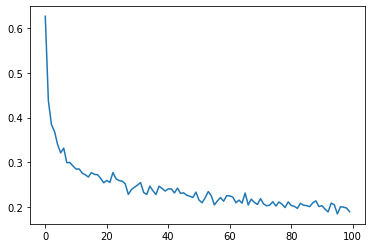

In [109]:
plt.plot(clf.history['loss'])

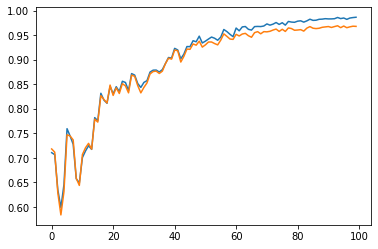

In [110]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

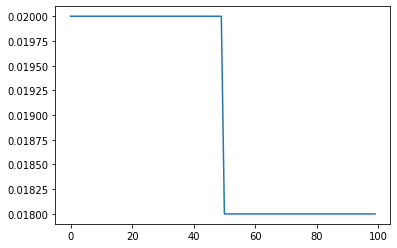

In [111]:
plt.plot(clf.history['lr'])

In [112]:
target = 'Class'

In [113]:
test_indices

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7822, 7823, 7824, 7825, 7826, 7827, 7828, 7829, 7830, 7831],
           dtype='int64', length=7832)

In [114]:




test.head()

,Contrast,Black Patch,Biffercation,CID,Class,OCL_STD2,FDA_STD2,SIGMA,OCL,FDA,FDA_STD,RVU,Set
0,0.166200,0.976471,1509,332.053514,classOne,0.053521,0.082080,67.018535,0.837883,0.450442,0.165506,0.533431,0
1,0.098199,0.989966,1339,265.142266,classOne,0.052430,0.084231,63.075490,0.841040,0.420273,0.147372,0.457116,0
2,0.054095,0.996549,1679,293.976355,classOne,0.046736,0.077678,60.396876,0.820264,0.417944,0.142840,0.505789,0
3,0.024822,0.998801,1902,289.341544,classOne,0.063880,0.079486,41.377170,0.751794,0.400578,0.134042,0.478189,0
4,0.129463,0.985666,1132,314.832926,classOne,0.079128,0.107797,49.720384,0.800174,0.436506,0.175556,0.459725,0


In [115]:
test.head()

,Contrast,Black Patch,Biffercation,CID,Class,OCL_STD2,FDA_STD2,SIGMA,OCL,FDA,FDA_STD,RVU,Set
0,0.166200,0.976471,1509,332.053514,classOne,0.053521,0.082080,67.018535,0.837883,0.450442,0.165506,0.533431,0
1,0.098199,0.989966,1339,265.142266,classOne,0.052430,0.084231,63.075490,0.841040,0.420273,0.147372,0.457116,0
2,0.054095,0.996549,1679,293.976355,classOne,0.046736,0.077678,60.396876,0.820264,0.417944,0.142840,0.505789,0
3,0.024822,0.998801,1902,289.341544,classOne,0.063880,0.079486,41.377170,0.751794,0.400578,0.134042,0.478189,0
4,0.129463,0.985666,1132,314.832926,classOne,0.079128,0.107797,49.720384,0.800174,0.436506,0.175556,0.459725,0


In [116]:
test.head()

,Contrast,Black Patch,Biffercation,CID,Class,OCL_STD2,FDA_STD2,SIGMA,OCL,FDA,FDA_STD,RVU,Set
0,0.166200,0.976471,1509,332.053514,classOne,0.053521,0.082080,67.018535,0.837883,0.450442,0.165506,0.533431,0
1,0.098199,0.989966,1339,265.142266,classOne,0.052430,0.084231,63.075490,0.841040,0.420273,0.147372,0.457116,0
2,0.054095,0.996549,1679,293.976355,classOne,0.046736,0.077678,60.396876,0.820264,0.417944,0.142840,0.505789,0
3,0.024822,0.998801,1902,289.341544,classOne,0.063880,0.079486,41.377170,0.751794,0.400578,0.134042,0.478189,0
4,0.129463,0.985666,1132,314.832926,classOne,0.079128,0.107797,49.720384,0.800174,0.436506,0.175556,0.459725,0


In [117]:
features

['Contrast',
 'Black Patch',
 'Biffercation',
 'CID',
 'OCL_STD2',
 'FDA_STD2',
 'SIGMA',
 'OCL',
 'FDA',
 'FDA_STD',
 'RVU']

In [118]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE : {clf.best_cost}")
print(f"FINAL TEST SCORE : {test_auc}")

BEST VALID SCORE : 0.9689567010676632
FINAL TEST SCORE : 0.9206360854376777


In [119]:
clf.predict(X_test)

array(['classOne', 'classOne', 'classOne', ..., 'classZero', 'classOne',
       'classZero'], dtype='<U9')

In [120]:
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [121]:
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [122]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE  : {loaded_test_auc}")

FINAL TEST SCORE  : 0.9206360854376777


In [123]:
assert(test_auc == loaded_test_auc)

In [124]:
loaded_clf.predict(X_test)

array(['classOne', 'classOne', 'classOne', ..., 'classZero', 'classOne',
       'classZero'], dtype='<U9')

In [125]:
clf.feature_importances_

array([0.08946655, 0.06212875, 0.15094861, 0.15524492, 0.06489847,
       0.01968365, 0.22688474, 0.02037617, 0.0928673 , 0.03564212,
       0.08185873])

In [126]:
explain_matrix, masks = clf.explain(X_test)

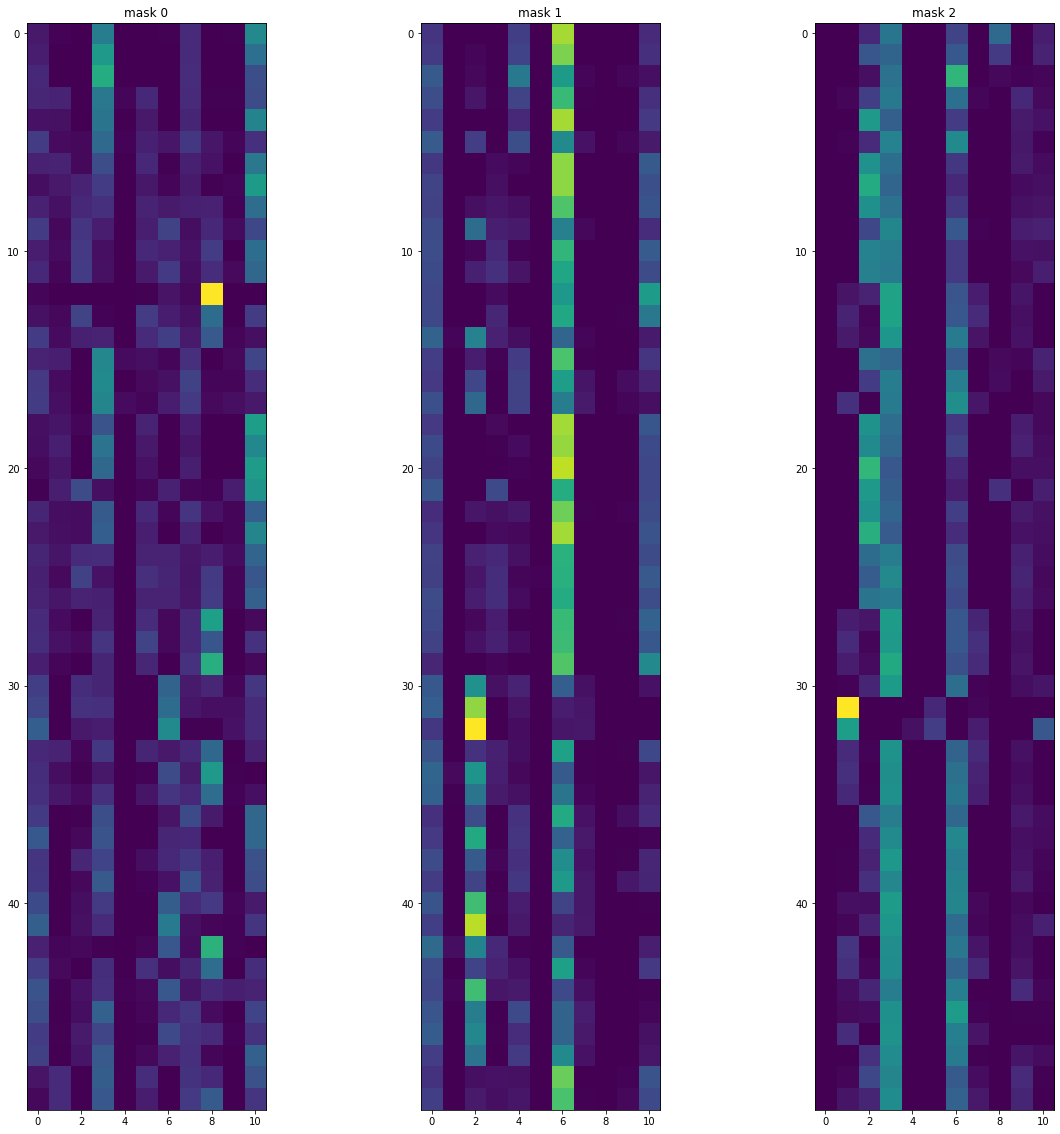

In [127]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")